In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

from merfish_datasets import merfish_datasets
directories = merfish_datasets
print(merfish_datasets)

{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [3]:
name = 'P28DR_ant'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
f_main    = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240411.h5ad'
f1   = full_dirc + 'detected_transcripts.csv'
# f2   = full_dirc + 'cell_metadata.csv'
fout = full_dirc + 'detected_transcripts_v1l23.csv'

In [4]:
adata = ad.read(f_main)
bound_l, bound_r, bound_d = adata.uns['bound_lrd']
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]

rotation_angle = adata.uns['rotation']
ref_line = np.array(adata.uns['ref_line'])

adatasub

View of AnnData object with n_obs × n_vars = 1796 × 500
    obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DreO_raw', 'DreO_high_pass', 'Cre_raw', 'Cre_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'FlpO_raw', 'FlpO_high_pass', 'Pvalb_raw', 'Pvalb_high_pass', 'Sst_raw', 'Sst_high_pass', 'Fth1_raw', 'Fth1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'depth', 'width', 'inside_v1l23'
    uns: 'bound_lrd', 'ref_line', 'rotation'
    obsm: 'blanks', 'pca'
    layers: 'norm'

In [5]:
# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((31,),
 array([1153, 1154, 1155, 1156, 1170, 1171, 1172, 1173, 1174, 1175, 1176,
        1177, 1178, 1179, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189,
        1190, 1191, 1192, 1195, 1196, 1197, 1198, 1199, 1200]))

# get transcripts in V1 L2/3

In [6]:
# go over all tranascripts - select only those that are within these FOVs
chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)

0 1.6030678749084473
1 3.135594129562378
2 4.50799560546875
3 5.9520440101623535
4 7.228755950927734
5 8.520211935043335
6 9.934896469116211
7 11.313356161117554
8 12.664168119430542
9 14.218795776367188
10 15.553154468536377
11 17.0622661113739
12 18.61021852493286
13 19.95292615890503
14 21.709895133972168
15 23.134294271469116
16 24.936737537384033
17 26.619410276412964
18 28.20659899711609
19 29.589346408843994
20 31.140422582626343
21 32.75350069999695
22 34.03885579109192
23 35.414145708084106
24 36.85707092285156
25 38.27519392967224
26 39.74636483192444
27 41.28817176818848
28 42.66495227813721
29 44.18877053260803
30 45.821558475494385
31 47.351394176483154
32 48.75305509567261
33 50.320945262908936
34 51.69110989570618
35 53.14994788169861
36 54.56598210334778
37 56.035475730895996
38 57.439810276031494
39 58.920427083969116
40 60.30179786682129
41 61.93734335899353
42 63.39135122299194
43 64.98146915435791
44 66.59063506126404
45 68.19246053695679
46 69.80753231048584
47 71.

In [7]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
50826053,21,0,3690.3184,9999.110,0.0,720.2441,116.15169,1153,Cdh4,ENSMUST00000000314,4207478901109100059
50826054,26,0,3695.7678,10002.117,0.0,770.7033,143.98760,1153,Cdh4,ENSMUST00000000314,4207478901109100059
50826055,55,0,3709.5159,10026.095,0.0,898.0000,366.00000,1153,Cdh4,ENSMUST00000000314,-1
50826056,71,0,3817.9000,10036.284,0.0,1901.5549,460.34763,1153,Cdh4,ENSMUST00000000314,-1
50826057,79,0,3695.2417,10044.341,0.0,765.8310,534.94580,1153,Cdh4,ENSMUST00000000314,4207478901155100049
...,...,...,...,...,...,...,...,...,...,...,...
55065182,153,523,3186.8093,11581.582,6.0,1724.7546,1696.18630,1200,Blank-24,Blank-24,4207478901703100008
55065183,181,532,3150.8718,11580.481,6.0,1392.0000,1686.00000,1200,Blank-33,Blank-33,-1
55065184,78,534,3183.7039,11477.989,6.0,1696.0000,737.00000,1200,Blank-35,Blank-35,4207478901657100089
55065185,104,534,3145.7212,11506.825,6.0,1344.3092,1004.00000,1200,Blank-35,Blank-35,4207478901656100003


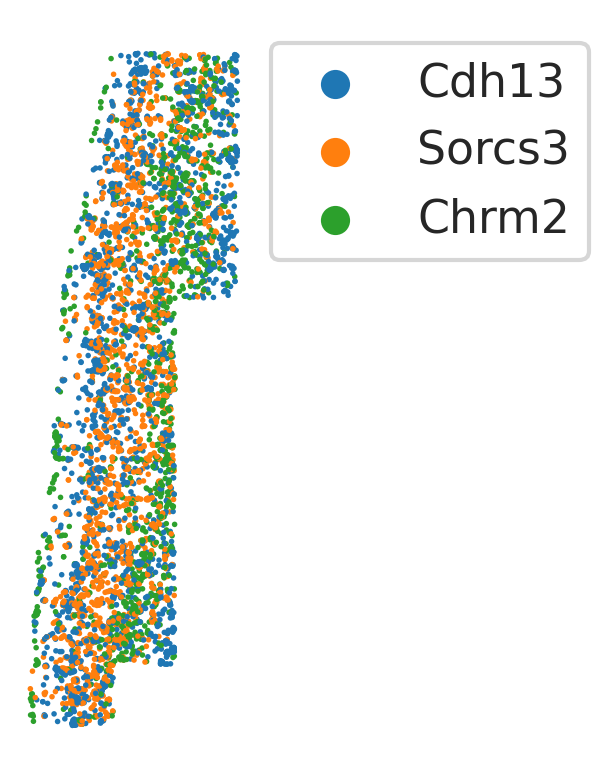

In [8]:
# check results
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  
fig, ax = plt.subplots()
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='global_x', y='global_y', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# rotate, calc depth and width, and viz

In [9]:
# reference line
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [10]:
%%time
x = df_v1l23['global_x'].values
y = df_v1l23['global_y'].values
xr, yr = utils_merfish.rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 

df_v1l23['x'] = xr
df_v1l23['y'] = yr
df_v1l23['depth'] = ref_line_obj.ndist_to_qps(XY)
df_v1l23['width'] = ref_line_obj.tdist_to_qps(XY)

cond_spots = np.all([
    df_v1l23['width'] > bound_l, 
    df_v1l23['width'] < bound_r, 
    df_v1l23['depth'] < bound_d, 
], axis=0)

df_v1l23 = df_v1l23[cond_spots]

CPU times: user 11.8 s, sys: 23.9 s, total: 35.7 s
Wall time: 36 s


In [11]:
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  

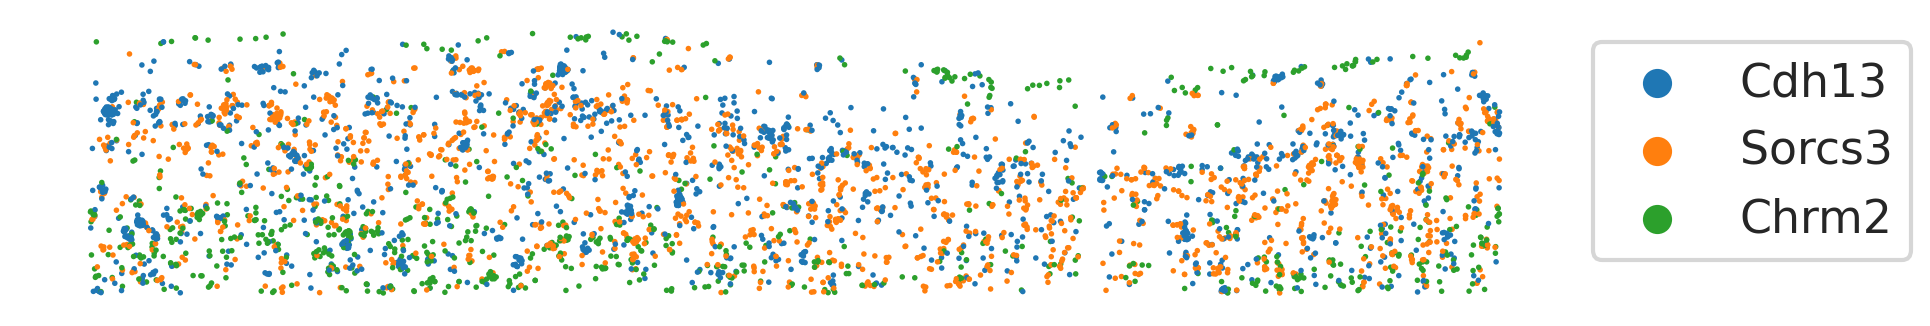

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# Save results

In [13]:
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
50826068,257,0,3643.3120,10175.111,0.0,10175.111,-3643.3120,1153,Cdh4,ENSMUST00000000314,-1,399.435159,3225.116008
50826105,39,2,3652.6000,10066.162,0.0,10066.162,-3652.6000,1153,Kcnn3,ENSMUST00000000811,-1,389.513734,3116.222863
50826122,94,2,3639.6362,10177.820,0.0,10177.820,-3639.6362,1153,Kcnn3,ENSMUST00000000811,-1,396.290159,3228.426469
50826130,49,4,3629.7040,10170.845,0.0,10170.845,-3629.7040,1153,Col6a1,ENSMUST00000001147,4207478901200100043,385.290602,3223.297242
50826132,22,5,3645.0400,10045.643,0.0,10045.643,-3645.0400,1153,Slc26a4,ENSMUST00000001253,4207478901154100039,378.479568,3097.343506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55065111,39,492,3196.6782,11422.324,6.0,11422.324,-3196.6782,1200,Sox10,ENSMUST00000230532,-1,77.688297,4568.879851
55065112,47,492,3185.0130,11432.206,6.0,11432.206,-3185.0130,1200,Sox10,ENSMUST00000230532,-1,64.563430,4576.720049
55065123,13,493,3201.9365,11419.307,6.0,11419.307,-3201.9365,1200,Robo1,ENSMUST00000232205,4207478901611100022,83.369369,4566.763859
55065135,10,499,3190.0747,11409.760,6.0,11409.760,-3190.0747,1200,Aqp4,ENSMUST00000238946,-1,73.229477,4555.404717


In [14]:
df_v1l23.to_csv(fout, header=True, index=False)
!head $fout

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
257,0,3643.312,10175.111,0.0,10175.111,-3643.3119999999994,1153,Cdh4,ENSMUST00000000314,-1,399.4351594922928,3225.1160075977614
39,2,3652.6,10066.162,0.0,10066.162,-3652.5999999999995,1153,Kcnn3,ENSMUST00000000811,-1,389.51373395735914,3116.2228633674895
94,2,3639.6362,10177.82,0.0,10177.82,-3639.6361999999995,1153,Kcnn3,ENSMUST00000000811,-1,396.2901585180938,3228.426469123332
49,4,3629.704,10170.845,0.0,10170.845,-3629.7039999999997,1153,Col6a1,ENSMUST00000001147,4207478901200100043,385.29060188105734,3223.297241537367
22,5,3645.04,10045.643,0.0,10045.643,-3645.0399999999995,1153,Slc26a4,ENSMUST00000001253,4207478901154100039,378.47956776179836,3097.343505926921
33,5,3647.2,10071.131,0.0,10071.131,-3647.1999999999994,1153,Slc26a4,ENSMUST00000001253,4207478901154100062,385.0666406041869,3122.0601848172782
42,8,3657.9849,10058.643,0.0,10058.643,-3657.9848999999995,1153,Smo,ENSMUST00000001812